## DATA SCIENCE CAPSTONE PROJECT
**Problem Statement:**

* It is a critical requirement for business to understand the value derived from a customer. RFM is a method used for analyzing customer value.
* Customer segmentation is the practice of segregating the customer base into groups of individuals based on some common characteristics such as age, gender, interests, and spending habits
* Perform customer segmentation using RFM analysis. The resulting segments can be ordered from most valuable (highest recency, frequency, and value) to least valuable (lowest recency, frequency, and value).

### Week 1:
### (A) DATA CLEANING

**(1) Reading Data and Preliminary Data Inspection**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import timedelta
from pandas import ExcelWriter
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

#### Dataset Description: This is a transnational data set which contains all the transactions that occurred between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique and all-occasion gifts.

* **InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* **StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* **Description:** Product (item) name. Nominal.
* **Quantity:** The quantities of each product (item) per transaction. Numeric.
* **InvoiceDate:** Invoice Date and time. Numeric, the day and time when each transaction was generated.
* **UnitPrice:** Unit price. Numeric, Product price per unit in sterling.
* **CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* **Country:** Country name. Nominal, the name of the country where each customer resides.

In [4]:
# Check shape of data
df.shape

(541909, 8)

In [5]:
# Check details of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**1(a) Missing values treatment:**

In [6]:
# Check missing values in data
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
#check for percentage of missing values
round(df.isnull().sum()/len(df)*100,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

As we can see two columns in data have missing values.

* Description - 0.27% (1454 nos.)
* CustomerID - 24.93% (135080)

**CustomerID** is important feature of our analysis since our analysis is centered around Customers only so we can not impute null values **CustomerID** with mean/ median/ mode in this case. We will check possibility to fill null values in **CustomerID** column by looking up for InvoiceNo of the row having null **CustomerID** in other rows where **CustomerID** is present. If there are still any null values in **CustomerID** after this process then we will drop complete row having missing **CustomerID**.

We can drop **Description** feature from our data since it is not not going to contribute in our model.

In [8]:
null_custid = set(df[df['CustomerID'].isnull()]['InvoiceNo'])
df[df['InvoiceNo'].isin(null_custid) & (~df['CustomerID'].isnull())]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

We could not find any value to impute null values in **CustomerID** column since all entries for a particular InvoiceNo have missing **CustomerID** if that particular InvoiceNo has null **CustomerID** in even one entry. So we will drop all rows having null values in **CustomerID**.

In [9]:
df = df.drop('Description', axis=1)
df = df.dropna()
df.shape

(406829, 7)

**1(b) Remove duplicate data records:**

In [10]:
df.duplicated().sum()

5227

Since our data is transactional data and it has duplicate entries for **InvoiceNo** and **CustomerID**, we will drop only those rows which are completely duplicated, not on the basis of any one particular column such as **InvoiceNo** or **CustomerID**, etc.

In [11]:
df = df.drop_duplicates()
df.shape

(401602, 7)

**1(c) Perform descriptive anaylysis on the given data:**

In [12]:
# CustomerID is 'float64', changing the datatype of CustomerId to string as Customer ID as numerical data does not make sense

df['CustomerID'] = df['CustomerID'].astype(str)

In [13]:
df.describe(datetime_is_numeric=True)

Quantity                    InvoiceDate      UnitPrice
count  401602.000000                         401602  401602.000000
mean       12.182579  2011-07-10 12:08:08.129839872       3.474064
min    -80995.000000            2010-12-01 08:26:00       0.000000
25%         2.000000            2011-04-06 15:02:00       1.250000
50%         5.000000            2011-07-29 15:40:00       1.950000
75%        12.000000            2011-10-20 11:58:00       3.750000
max     80995.000000            2011-12-09 12:50:00   38970.000000
std       250.283248                            NaN      69.764209

* **Quantity:** Average quantity of each product in transaction is 12.18. Also note that minimum value in Quantity column is negative. This implies that some customers had returned the product during our period of analysis.
* **InvoiceDate:** Our data has transaction between 01-12-2010 to 09-12-2011
* **UnitPrice:** Average price of each product in transactions is 3.47

In [14]:
# for object category datatypes
df.describe(include=['O']) 

InvoiceNo StockCode CustomerID         Country
count      401602    401602     401602          401602
unique      22190      3684       4372              37
top        576339    85123A    17841.0  United Kingdom
freq          542      2065       7812          356726

* **InvoiceNo:** Total entries in preprocessed data are 4,01,602 but transactions are 22,190. Most number of entries (count of unique products) are in Invoice No. '576339' and is 542 nos.
* **StockCode:** There are total 3684 unique products in our data and product with stock code '85123A' appears most frequently (2065 times) in our data.
* **CustomerID:** There are 4372 unique customers in our final preprocessed data. Customer with ID '17841' appears most frequently in data (7812 times)
* **Country:** Company has customers across 37 countries. Most entries are from United Kingdom in our dataset (356726)

### (B) Data Transformation

**(2) Perform Cohort Analysis**

**2(a) Create month cohort of customers and analyze active customers in each cohort:**

In [15]:
# Convert to InvoiceDate to Year-Month format
df['month_year'] = df['InvoiceDate'].dt.to_period('M')
df['month_year'].nunique()

13

In [16]:
month_cohort = df.groupby('month_year')['CustomerID'].nunique()
month_cohort

month_year
2010-12     948
2011-01     783
2011-02     798
2011-03    1020
2011-04     899
2011-05    1079
2011-06    1051
2011-07     993
2011-08     980
2011-09    1302
2011-10    1425
2011-11    1711
2011-12     686
Freq: M, Name: CustomerID, dtype: int64

Text(0.5, 1.0, 'No. of active customers in each month')

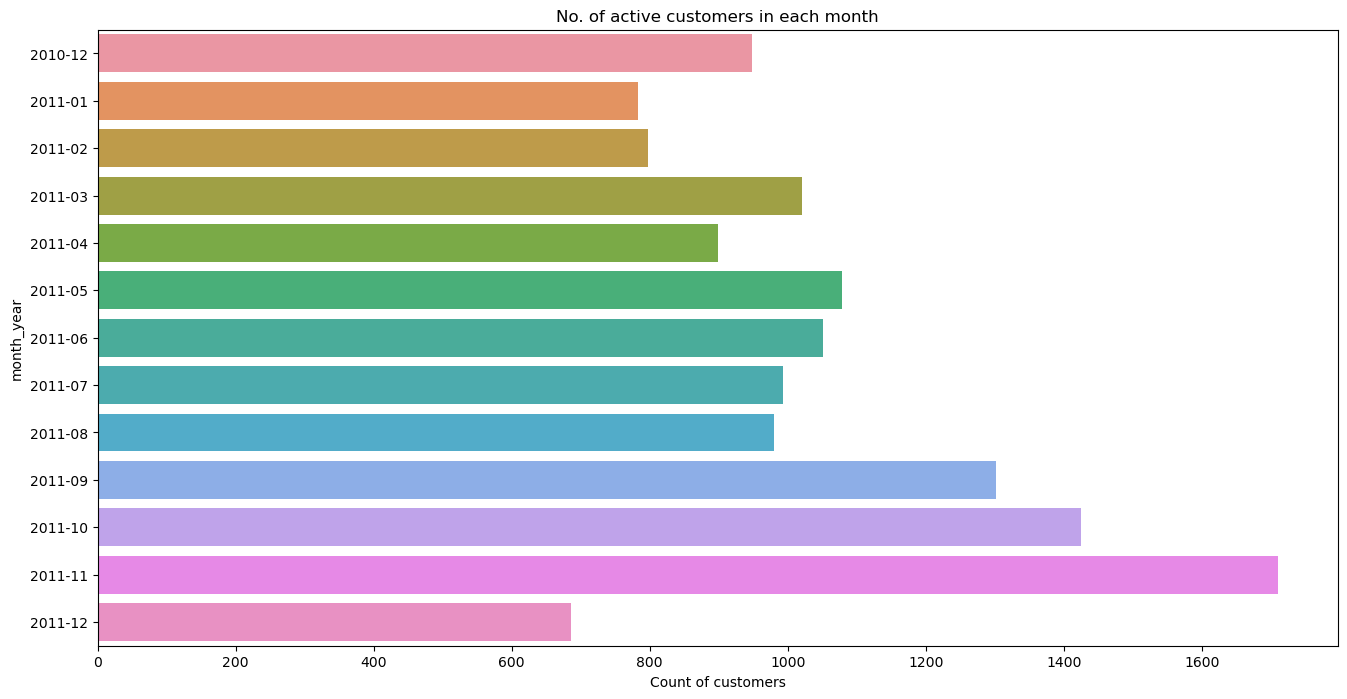

In [17]:
plt.figure(figsize=(16,8))
sns.barplot(y = month_cohort.index, x = month_cohort.values);
plt.xlabel("Count of customers")
plt.title("No. of active customers in each month")

**2(b) Analyze the retention rate of customers:**

In [18]:
month_cohort - month_cohort.shift(1)

month_year
2010-12       NaN
2011-01    -165.0
2011-02      15.0
2011-03     222.0
2011-04    -121.0
2011-05     180.0
2011-06     -28.0
2011-07     -58.0
2011-08     -13.0
2011-09     322.0
2011-10     123.0
2011-11     286.0
2011-12   -1025.0
Freq: M, Name: CustomerID, dtype: float64

In [19]:
retention_rate = round(month_cohort.pct_change(periods=1)*100,2)
retention_rate

month_year
2010-12      NaN
2011-01   -17.41
2011-02     1.92
2011-03    27.82
2011-04   -11.86
2011-05    20.02
2011-06    -2.59
2011-07    -5.52
2011-08    -1.31
2011-09    32.86
2011-10     9.45
2011-11    20.07
2011-12   -59.91
Freq: M, Name: CustomerID, dtype: float64

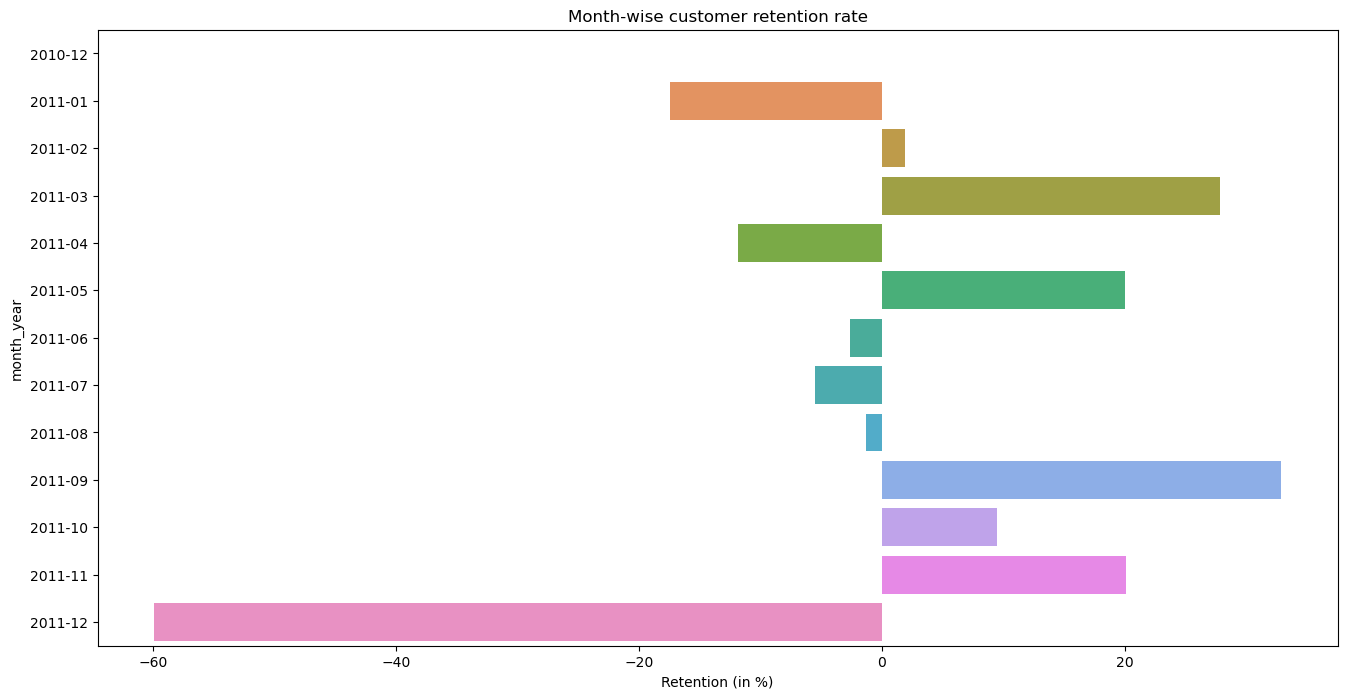

In [20]:
plt.figure(figsize=(16,8))
sns.barplot(y = retention_rate.index, x = retention_rate.values);
plt.xlabel("Retention (in %)")
plt.title("Month-wise customer retention rate");

### Week 2:
### Monetary analysis:

In [21]:
df['amount'] = df['Quantity']*df['UnitPrice']
df.head()

InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice CustomerID  \
0    536365    85123A         6 2010-12-01 08:26:00       2.55    17850.0   
1    536365     71053         6 2010-12-01 08:26:00       3.39    17850.0   
2    536365    84406B         8 2010-12-01 08:26:00       2.75    17850.0   
3    536365    84029G         6 2010-12-01 08:26:00       3.39    17850.0   
4    536365    84029E         6 2010-12-01 08:26:00       3.39    17850.0   

          Country month_year  amount  
0  United Kingdom    2010-12   15.30  
1  United Kingdom    2010-12   20.34  
2  United Kingdom    2010-12   22.00  
3  United Kingdom    2010-12   20.34  
4  United Kingdom    2010-12   20.34

In [22]:
df_monetary = df.groupby('CustomerID').sum()['amount'].reset_index()
df_monetary

CustomerID   amount
0       12346.0     0.00
1       12347.0  4310.00
2       12348.0  1797.24
3       12349.0  1757.55
4       12350.0   334.40
...         ...      ...
4367    18280.0   180.60
4368    18281.0    80.82
4369    18282.0   176.60
4370    18283.0  2045.53
4371    18287.0  1837.28

[4372 rows x 2 columns]

### Frequency Analysis:

In [23]:
df_frequency = df.groupby('CustomerID').nunique()['InvoiceNo'].reset_index()
df_frequency

CustomerID  InvoiceNo
0       12346.0          2
1       12347.0          7
2       12348.0          4
3       12349.0          1
4       12350.0          1
...         ...        ...
4367    18280.0          1
4368    18281.0          1
4369    18282.0          3
4370    18283.0         16
4371    18287.0          3

[4372 rows x 2 columns]

###  Recency Analysis:

In [24]:
#fix reference date for calculating recency as last transaction day in data + 1 day
ref_day = max(df['InvoiceDate']) + timedelta(days=1)
df['days_to_last_order'] = (ref_day - df['InvoiceDate']).dt.days
df.head()

InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice CustomerID  \
0    536365    85123A         6 2010-12-01 08:26:00       2.55    17850.0   
1    536365     71053         6 2010-12-01 08:26:00       3.39    17850.0   
2    536365    84406B         8 2010-12-01 08:26:00       2.75    17850.0   
3    536365    84029G         6 2010-12-01 08:26:00       3.39    17850.0   
4    536365    84029E         6 2010-12-01 08:26:00       3.39    17850.0   

          Country month_year  amount  days_to_last_order  
0  United Kingdom    2010-12   15.30                 374  
1  United Kingdom    2010-12   20.34                 374  
2  United Kingdom    2010-12   22.00                 374  
3  United Kingdom    2010-12   20.34                 374  
4  United Kingdom    2010-12   20.34                 374

In [25]:
df_recency = df.groupby('CustomerID')['days_to_last_order'].min().reset_index()
df_recency

CustomerID  days_to_last_order
0       12346.0                 326
1       12347.0                   2
2       12348.0                  75
3       12349.0                  19
4       12350.0                 310
...         ...                 ...
4367    18280.0                 278
4368    18281.0                 181
4369    18282.0                   8
4370    18283.0                   4
4371    18287.0                  43

[4372 rows x 2 columns]

### Calculate RFM metrics:

In [26]:
df_rf = pd.merge(df_recency, df_frequency,  on='CustomerID', how='inner')
df_rfm = pd.merge(df_rf, df_monetary, on='CustomerID', how='inner')
df_rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
df_rfm.head()

CustomerID  Recency  Frequency  Monetary
0    12346.0      326          2      0.00
1    12347.0        2          7   4310.00
2    12348.0       75          4   1797.24
3    12349.0       19          1   1757.55
4    12350.0      310          1    334.40

### Build RFM Segments:

newest    2734
newer      588
medium     416
older      353
oldest     281
Name: recency_labels, dtype: int64

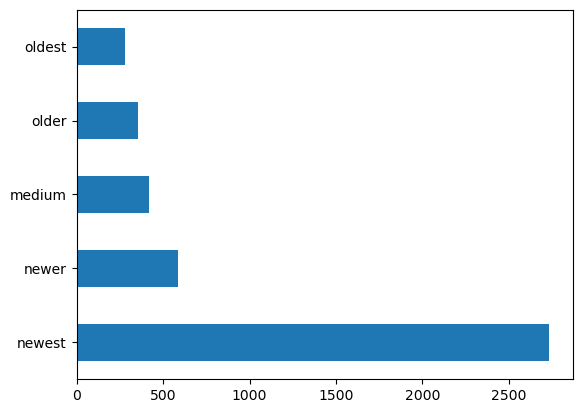

In [27]:
df_rfm['recency_labels'] = pd.cut(df_rfm['Recency'], bins=5,labels=['newest', 'newer', 'medium', 'older', 'oldest'])
df_rfm['recency_labels'].value_counts().plot(kind='barh');
df_rfm['recency_labels'].value_counts()

lowest     4348
lower        18
medium        3
highest       2
higher        1
Name: frequency_labels, dtype: int64

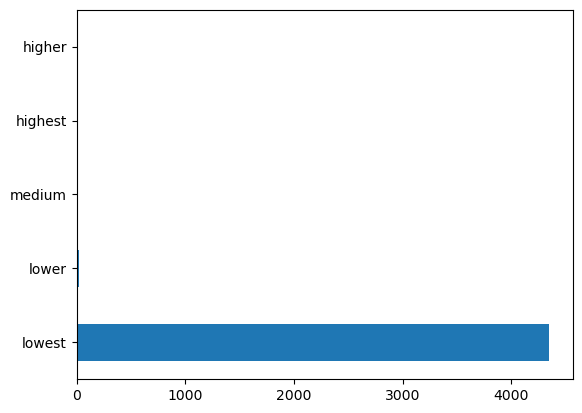

In [28]:
df_rfm['frequency_labels'] = pd.cut(df_rfm['Frequency'], bins=5, labels=['lowest', 'lower', 'medium', 'higher', 'highest'])
df_rfm['frequency_labels'].value_counts().plot(kind='barh');
df_rfm['frequency_labels'].value_counts()

smallest    4357
smaller        9
medium         3
largest        2
larger         1
Name: monetary_labels, dtype: int64

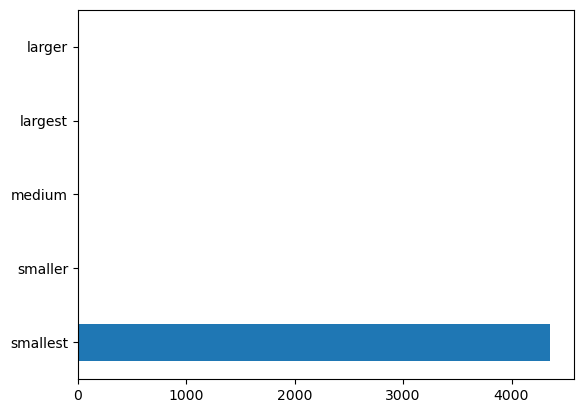

In [29]:
df_rfm['monetary_labels'] = pd.cut(df_rfm['Monetary'], bins=5, labels=['smallest', 'smaller', 'medium', 'larger', 'largest'])
df_rfm['monetary_labels'].value_counts().plot(kind='barh');
df_rfm['monetary_labels'].value_counts()

In [30]:
df_rfm['rfm_segment'] = df_rfm[['recency_labels','frequency_labels','monetary_labels']].agg('-'.join, axis=1)
df_rfm.head()

CustomerID  Recency  Frequency  Monetary recency_labels frequency_labels  \
0    12346.0      326          2      0.00         oldest           lowest   
1    12347.0        2          7   4310.00         newest           lowest   
2    12348.0       75          4   1797.24         newest           lowest   
3    12349.0       19          1   1757.55         newest           lowest   
4    12350.0      310          1    334.40         oldest           lowest   

  monetary_labels             rfm_segment  
0        smallest  oldest-lowest-smallest  
1        smallest  newest-lowest-smallest  
2        smallest  newest-lowest-smallest  
3        smallest  newest-lowest-smallest  
4        smallest  oldest-lowest-smallest

### RFM Score:

In [32]:
recency_dict = {'newest': 5, 'newer':4, 'medium': 3, 'older':2, 'oldest':1}
frequency_dict = {'lowest':1, 'lower':2, 'medium': 3, 'higher':4, 'highest':5}
monetary_dict = {'smallest':1, 'smaller':2, 'medium': 3, 'larger':4, 'largest':5}

df_rfm['rfm_score'] = df_rfm['recency_labels'].map(recency_dict).astype(int)+ df_rfm['frequency_labels'].map(frequency_dict).astype(int) + df_rfm['monetary_labels'].map(monetary_dict).astype(int)
df_rfm.head(20)

CustomerID  Recency  Frequency  Monetary recency_labels frequency_labels  \
0     12346.0      326          2      0.00         oldest           lowest   
1     12347.0        2          7   4310.00         newest           lowest   
2     12348.0       75          4   1797.24         newest           lowest   
3     12349.0       19          1   1757.55         newest           lowest   
4     12350.0      310          1    334.40         oldest           lowest   
5     12352.0       36         11   1545.41         newest           lowest   
6     12353.0      204          1     89.00         medium           lowest   
7     12354.0      232          1   1079.40          older           lowest   
8     12355.0      214          1    459.40         medium           lowest   
9     12356.0       23          3   2811.43         newest           lowest   
10    12357.0       33          1   6207.67         newest           lowest   
11    12358.0        2          2   1168.06         newest           lowest   
12    12359.0        8          6   6182.98         newest           lowest   
13    12360.0       52          3   2662.06         newest           lowest   
14    12361.0      287          1    189.90          older           lowest   
15    12362.0        3         13   5154.58         newest           lowest   
16    12363.0      110          2    552.00          newer           lowest   
17    12364.0        8          4   1313.10         newest           lowest   
18    12365.0      291          3    320.69          older           lowest   
19    12367.0        4          1    168.90         newest           lowest   

   monetary_labels             rfm_segment  rfm_score  
0         smallest  oldest-lowest-smallest          3  
1         smallest  newest-lowest-smallest          7  
2         smallest  newest-lowest-smallest          7  
3         smallest  newest-lowest-smallest          7  
4         smallest  oldest-lowest-smallest          3  
5         smallest  newest-lowest-smallest          7  
6         smallest  medium-lowest-smallest          5  
7         smallest   older-lowest-smallest          4  
8         smallest  medium-lowest-smallest          5  
9         smallest  newest-lowest-smallest          7  
10        smallest  newest-lowest-smallest          7  
11        smallest  newest-lowest-smallest          7  
12        smallest  newest-lowest-smallest          7  
13        smallest  newest-lowest-smallest          7  
14        smallest   older-lowest-smallest          4  
15        smallest  newest-lowest-smallest          7  
16        smallest   newer-lowest-smallest          6  
17        smallest  newest-lowest-smallest          7  
18        smallest   older-lowest-smallest          4  
19        smallest  newest-lowest-smallest          7

### Analyze RFM Segment and Score:

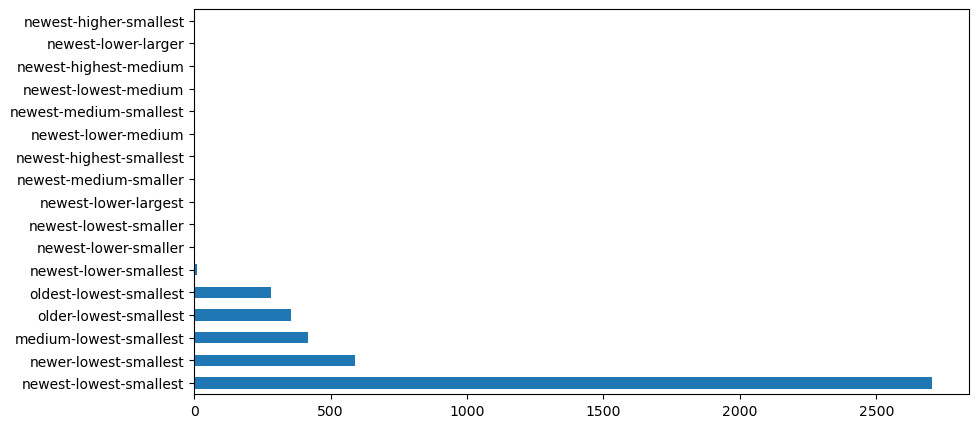

In [33]:
df_rfm['rfm_segment'].value_counts().plot(kind='barh', figsize=(10, 5));

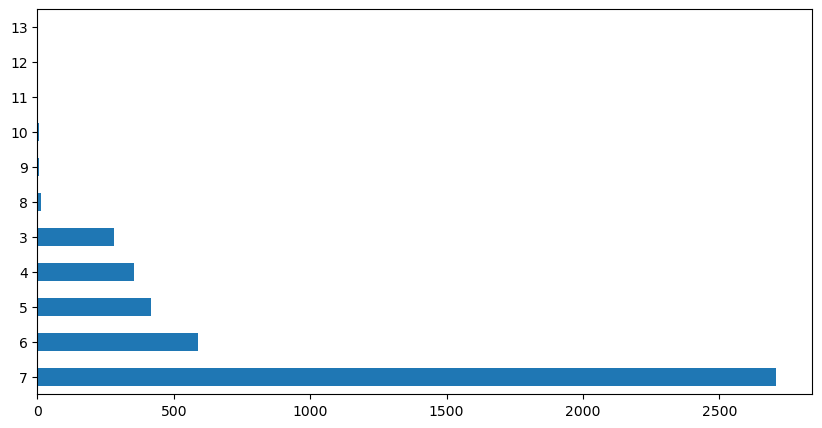

In [34]:
df_rfm['rfm_score'].value_counts().plot(kind='barh', figsize=(10, 5));

### Week 3:
### Data Modeling:

**1. Create clusters using k-means clustering algorithm.**

   **a. Prepare the data for the algorithm. If the data is asymmetrically distributed, manage the skewness with appropriate transformation. Standardize the data.**

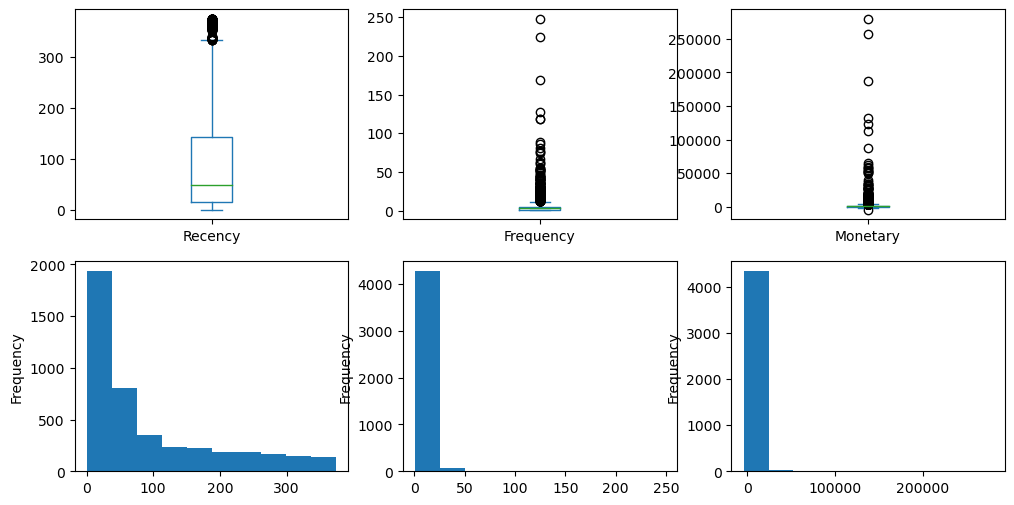

In [35]:
plt.figure(figsize=(12,6))

for i, feature in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(2,3,i+1)
    df_rfm[feature].plot(kind='box')
    plt.subplot(2,3,i+1+3)
    df_rfm[feature].plot(kind='hist')

 Frequency and Monetary features in above data seem to have lot of outliers. Lets drop them.

In [36]:
df_rfm = df_rfm[(df_rfm['Frequency']<60) & (df_rfm['Monetary']<40000)]
df_rfm.shape

(4346, 9)

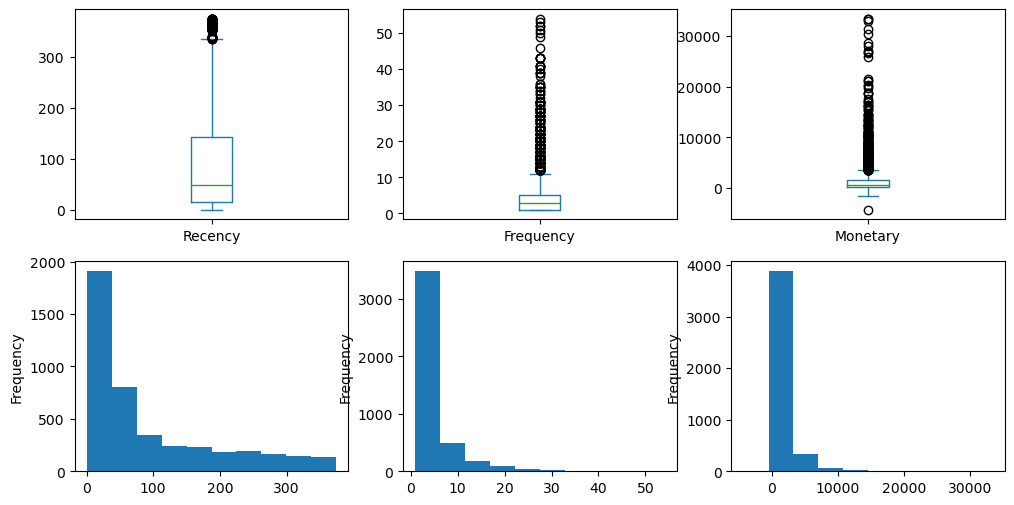

In [37]:
plt.figure(figsize=(12,6))

for i, feature in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(2,3,i+1)
    df_rfm[feature].plot(kind='box')
    plt.subplot(2,3,i+1+3)
    df_rfm[feature].plot(kind='hist')

Now since all three features have right skewed data therefore we will use log transformation of these features in our model.

In [38]:
df_rfm_log_trans = pd.DataFrame()
df_rfm_log_trans['Recency'] = np.log(df_rfm['Recency'])
df_rfm_log_trans['Frequency'] = np.log(df_rfm['Frequency'])
df_rfm_log_trans['Monetary'] = np.log(df_rfm['Monetary']-df_rfm['Monetary'].min()+1)

In [39]:
#Standard Scalar Transformation
scaler = StandardScaler()

df_rfm_scaled = scaler.fit_transform(df_rfm_log_trans[['Recency', 'Frequency', 'Monetary']])
df_rfm_scaled

df_rfm_scaled = pd.DataFrame(df_rfm_scaled)
df_rfm_scaled.columns = ['Recency', 'Frequency', 'Monetary']
df_rfm_scaled.head()

Recency  Frequency  Monetary
0  1.402988  -0.388507 -0.770922
1 -2.100874   0.967301  1.485132
2  0.392218   0.361655  0.364190
3 -0.552268  -1.138669  0.342970
4  1.368370  -1.138669 -0.527416

**b. Build K-Means Clustering Model and Decide the optimum number of clusters to be formed.**

In [40]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(df_rfm_scaled)

KMeans(max_iter=50, n_clusters=3)

In [41]:
kmeans.labels_

array([1, 2, 0, ..., 0, 2, 0])

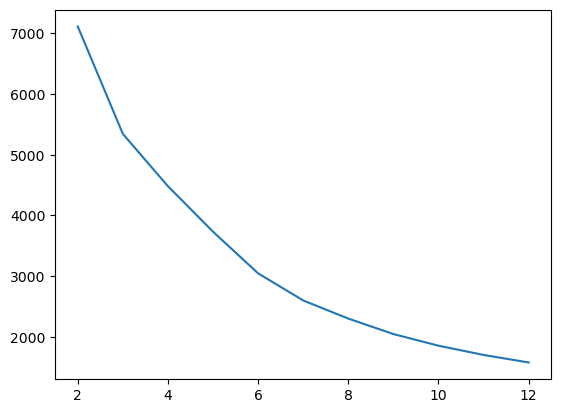

In [42]:
# Finding the Optimal Number of Clusters with the help of Elbow Curve/ SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
    kmeans.fit(df_rfm_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(range_n_clusters,ssd);

In [43]:
# Creating dataframe for exporting to create visualization in tableau later
df_inertia = pd.DataFrame(list(zip(range_n_clusters, ssd)), columns=['clusters', 'intertia'])
df_inertia

clusters     intertia
0          2  7113.097396
1          3  5343.136928
2          4  4480.966244
3          5  3731.243621
4          6  3044.935139
5          7  2598.361979
6          8  2299.656806
7          9  2045.030011
8         10  1852.996153
9         11  1700.765255
10        12  1576.579064

In [44]:
# Finding the Optimal Number of Clusters with the help of Silhouette Analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for num_clusters in range_n_clusters:    
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_rfm_scaled)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(df_rfm_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.44132753537785846
For n_clusters=3, the silhouette score is 0.3802185902754405
For n_clusters=4, the silhouette score is 0.3625717364351973
For n_clusters=5, the silhouette score is 0.3669477142535623
For n_clusters=6, the silhouette score is 0.35218360582851316
For n_clusters=7, the silhouette score is 0.34297910328413966
For n_clusters=8, the silhouette score is 0.3426607794802709
For n_clusters=9, the silhouette score is 0.346439804359832
For n_clusters=10, the silhouette score is 0.35717287436024564


**We can select optimum number of clusters as 3 in our final model**

In [60]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(df_rfm_scaled)

KMeans(max_iter=50, n_clusters=3)

### **c. Analyze these clusters and comment on the results.**

In [61]:
# assign the label
df_rfm['Cluster_Id'] = kmeans.labels_
df_rfm.head()

CustomerID  Recency  Frequency  Monetary recency_labels frequency_labels  \
0    12346.0      326          2      0.00         oldest           lowest   
1    12347.0        2          7   4310.00         newest           lowest   
2    12348.0       75          4   1797.24         newest           lowest   
3    12349.0       19          1   1757.55         newest           lowest   
4    12350.0      310          1    334.40         oldest           lowest   

  monetary_labels             rfm_segment  rfm_score  Cluster_Id  
0        smallest  oldest-lowest-smallest          3           0  
1        smallest  newest-lowest-smallest          7           2  
2        smallest  newest-lowest-smallest          7           1  
3        smallest  newest-lowest-smallest          7           0  
4        smallest  oldest-lowest-smallest          3           0

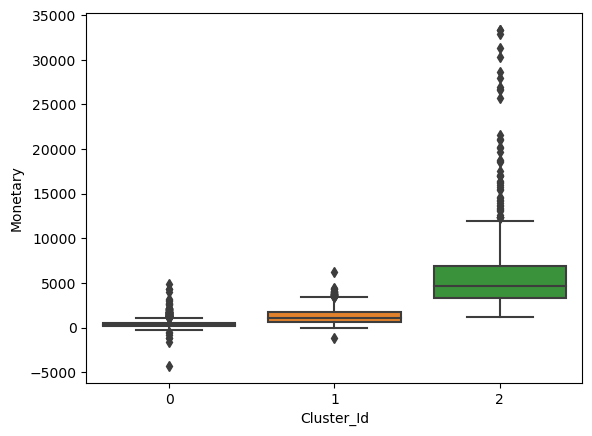

In [62]:
# Box plot to visualize Cluster Id vs Monetary
sns.boxplot(x='Cluster_Id', y='Monetary', data=df_rfm);

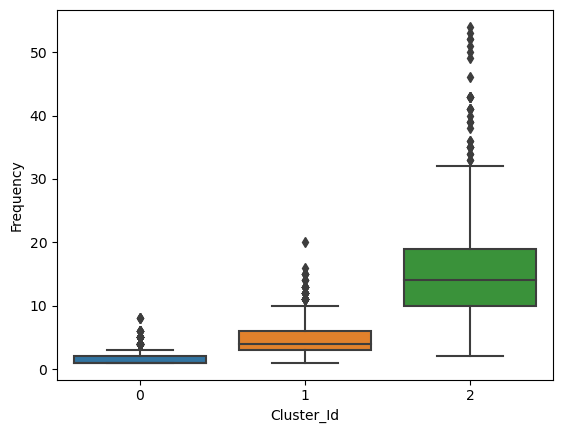

In [63]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=df_rfm);

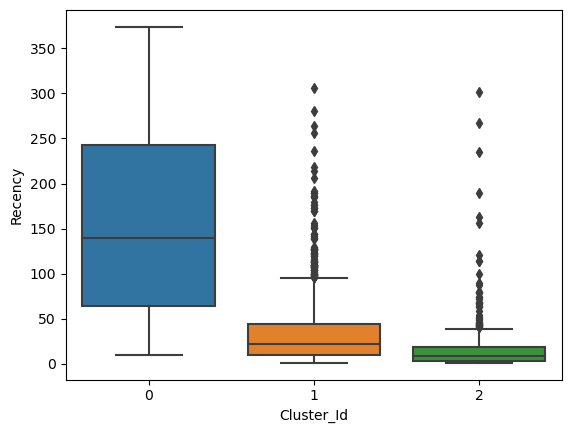

In [64]:
# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=df_rfm);

### Inference:
As we can observe from above boxplots that our model has nicely created 3 segements of customer with the interpretation as below:

* Customers with **Cluster Id 0** are less frequent buyers with low monetary expenditure and also they have not purchased anything in recent time and hence least important for business.
* Customers with **Cluster Id 1** are the customers having Recency, Frequency and Monetary score in the medium range.
* Customers with **Cluster Id 2** are the most frequent buyers, spending high amount and recently placing orders so they are the most important customers from business point of view.


## Week 4:

### Data reporting:

1. Create a dashboard in tableau by choosing appropriate chart types and metrics useful for the business. The dashboard must entail the following:

 a. Country-wise analysis to demonstrate average spend. Use a bar chart to show the monthly figures
 
 b. Bar graph of top 15 products which are mostly ordered by the users to show the number of products sold
 
 c. Bar graph to show the count of orders vs. hours throughout the day
 
 d. Plot the distribution of RFM values using histogram and frequency charts
 
 e. Plot error (cost) vs. number of clusters selected
 
 f. Visualize to compare the RFM values of the clusters using heatmap

In [65]:
# Writing dataframe to excel file for creating visualization in tableau
writer = pd.ExcelWriter('C:\\Users\\Admin\\Desktop\\Project_3\\Project 3\\output_data.xlsx', engine='xlsxwriter')

df.to_excel(writer, sheet_name='master_data', index=False)
df_rfm.to_excel(writer, sheet_name='rfm_data', index=False)
df_inertia.to_excel(writer, sheet_name='inertia', index=False)
writer.save()

In [3]:
product_desc = pd.read_excel("Online Retail.xlsx")
product_desc = product_desc[['StockCode', 'Description']]
product_desc = product_desc.drop_duplicates()
product_desc.to_excel('product_desc.xlsx', index=False)